In [1]:
from __future__ import absolute_import
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import random
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Lambda, Reshape
from keras.layers import AveragePooling1D,Conv1D
from keras import backend as K
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold 
from scipy.spatial.distance import euclidean

In [20]:
#Siamese Network Implementation 
num_classes = 12
epochs = 20
 
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))
 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
 
def contrastive_loss(y_true, y_pred):
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs_new3(x, digit_indices):
    pairs = []
    labels = []
    
    for d in range(num_classes):
        # Skip if no samples for this class
        if len(digit_indices[d]) == 0:
            continue
            
        n = len(digit_indices[d]) - 1
        if n <= 0:
            continue
            
        for i in range(n):
            # Create positive pair
            randomIndiceTrue = -1
            while True:
                if randomIndiceTrue != i:
                    break
                else:
                    randomIndiceTrue = random.randrange(0, len(digit_indices[d]))
            
            z1, z2 = digit_indices[d][i], digit_indices[d][randomIndiceTrue]
            pairs += [[x[z1], x[z2]]]
            labels += [1]  # Add positive label immediately
            
            # Find a different class that has samples for negative pair
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            
            # Keep trying until we find a class with samples
            attempts = 0
            while len(digit_indices[dn]) == 0 and attempts < num_classes:
                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                attempts += 1
            
            # If no other class has samples, create a dummy negative pair
            if len(digit_indices[dn]) == 0:
                # Use the same sample twice as a fallback
                z1, z2 = digit_indices[d][i], digit_indices[d][i]
                pairs += [[x[z1], x[z2]]]
                labels += [0]
            else:
                randomIndiceFalse = random.randrange(0, len(digit_indices[dn]))
                z1, z2 = digit_indices[d][i], digit_indices[dn][randomIndiceFalse]
                pairs += [[x[z1], x[z2]]]
                labels += [0]
                
    return np.array(pairs), np.array(labels)



def create_base_net_new2(input_shape):
    height=376
    depth=1
    num_classes=12
    input = Input(shape = input_shape)
    x = Reshape((height, depth))(input)
    x = Conv1D(12, 3, strides=1, padding='valid', activation='relu')(x)
    x = AveragePooling1D(3)(x)
    x = Conv1D(8, 3, strides=1, padding='valid', activation='relu')(x)
    x = AveragePooling1D(3)(x)
    x = Conv1D(6, 3, strides=1, padding='valid', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation = 'relu')(x)
    model = Model(input, x)
    model.summary()
    return model


def get_f1(y_true, y_pred): 
    pred = K.cast(y_pred < 0.5, y_true.dtype)
    true_positives = K.sum(K.round(K.clip(y_true * pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

def compute_f1(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    pred=pred*1
    TN,FP,FN,TP=confusion_matrix(y_true, pred).ravel()

    recall = TP/(TP+FN)
    precision=TP/(TP+FP)

    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

    

In [21]:
def compute_cosine_f1(t_pairs, t_y):
    cosine_threshold=0.6
    cTP=0
    cFP=0
    cFN=0
    cTN=0
    for i in range(np.shape(t_y)[0]):
        cos_result=cosine_similarity(t_pairs[i, 0].reshape(1, -1), t_pairs[i, 1].reshape(1, -1))
        if t_y[i]==1 and cos_result>=cosine_threshold:
            cTP=cTP+1
        elif t_y[i]!=1 and cos_result>=cosine_threshold:
            cFP=cFP+1
        elif t_y[i]==1 and cos_result<cosine_threshold:
            cFN=cFN+1
        elif t_y[i]!=1 and cos_result<cosine_threshold:
            cTN=cTN+1
        
    recall = cTP/(cTP+cFN)
    
    precision=cTP/(cTP+cFP)
    f1_cosine_val = 2*(precision*recall)/(precision+recall)
    return f1_cosine_val



In [22]:
def manhattan_distance(point1, point2):
    return np.sum(np.abs(point1 - point2))

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_manhattan_f1(t_pairs, t_y):
    manhattan_threshold = 0.9
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    # Max-Min Normalizasyonu
    t_pairs_normalized = np.array([min_max_normalize(pair) for pair in t_pairs])
    
    for i in range(np.shape(t_y)[0]):
        result = manhattan_distance(t_pairs_normalized[i, 0], t_pairs_normalized[i, 1])
        if t_y[i] == 1 and result >= manhattan_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= manhattan_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < manhattan_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < manhattan_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_manhattan_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_manhattan_val


In [16]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_euclidean_f1(t_pairs, t_y):
    euclidean_threshold = 0.7
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    # Max-Min Normalizasyonu
    t_pairs_normalized = np.array([min_max_normalize(pair) for pair in t_pairs])
    
    for i in range(np.shape(t_y)[0]):
        result = euclidean_distance(t_pairs_normalized[i, 0], t_pairs_normalized[i, 1])
        if t_y[i] == 1 and result >= euclidean_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= euclidean_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < euclidean_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < euclidean_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_euclidean_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_euclidean_val


In [17]:
from scipy.spatial.distance import canberra

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_canberra_f1(t_pairs, t_y):
    canberra_threshold = 0.9
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply Max-Min normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Calculate Canberra distance after normalization
        result = canberra(t_pair_normalized[0].flatten(), t_pair_normalized[1].flatten())  # Flatten to 1-D arrays
        
        if t_y[i] == 1 and result >= canberra_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= canberra_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < canberra_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < canberra_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_canberra_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_canberra_val


In [7]:
from scipy.stats import pearsonr

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_pearsonr_f1(t_pairs, t_y):
    pearsonr_threshold = 0.65
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the 2-D arrays to 1-D arrays
        t_pair_normalized_1d = t_pair_normalized[0].flatten()
        t_pair_normalized_2d = t_pair_normalized[1].flatten()
        
        # Calculate the Pearson correlation coefficient
        result, _ = pearsonr(t_pair_normalized_1d, t_pair_normalized_2d)
        
        if t_y[i] == 1 and abs(result) >= pearsonr_threshold:
            cTP += 1
        elif t_y[i] != 1 and abs(result) >= pearsonr_threshold:
            cFP += 1
        elif t_y[i] == 1 and abs(result) < pearsonr_threshold:
            cFN += 1
        elif t_y[i] != 1 and abs(result) < pearsonr_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_pearsonr_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_pearsonr_val


In [8]:
from scipy.spatial.distance import braycurtis

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_bray_curtis_f1(t_pairs, t_y):
    bray_curtis_threshold = 0.6
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the arrays to 1-D
        t_pair_normalized_1d = t_pair_normalized[0].flatten()
        t_pair_normalized_2d = t_pair_normalized[1].flatten()
        
        # Calculate the Bray-Curtis dissimilarity
        result = braycurtis(t_pair_normalized_1d, t_pair_normalized_2d)
        
        if t_y[i] == 1 and result <= bray_curtis_threshold:
            cTP += 1
        elif t_y[i] != 1 and result <= bray_curtis_threshold:
            cFP += 1
        elif t_y[i] == 1 and result > bray_curtis_threshold:
            cFN += 1
        elif t_y[i] != 1 and result > bray_curtis_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_bray_curtis_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_bray_curtis_val


In [9]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def calculate_jaccard_similarity(set1, set2):
    intersection = np.sum(set1 & set2)
    union = np.sum(set1 | set2)
    if union == 0:
        return 0.0
    return intersection / union

def compute_jaccard_f1(t_pairs, t_y):
    jaccard_threshold = 0.4
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the arrays to 1-D and convert to binary (0 or 1)
        t_pair_normalized_1d = (t_pair_normalized[0] >= 0.5).astype(int)
        t_pair_normalized_2d = (t_pair_normalized[1] >= 0.5).astype(int)
        
        # Calculate the Jaccard similarity
        result = calculate_jaccard_similarity(t_pair_normalized_1d, t_pair_normalized_2d)
        
        if t_y[i] == 1 and result >= jaccard_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= jaccard_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < jaccard_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < jaccard_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_jaccard_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_jaccard_val


In [23]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data


def compute_hamming_f1(t_pairs, t_y):
    hamming_threshold = 0.9
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the arrays to 1-D and convert to binary (0 or 1)
        t_pair_normalized_1d = (t_pair_normalized[0] >= 0.5).astype(int)
        t_pair_normalized_2d = (t_pair_normalized[1] >= 0.5).astype(int)
        
        # Calculate Hamming distance
        result = np.sum(t_pair_normalized_1d != t_pair_normalized_2d) / len(t_pair_normalized_1d)
        
        if t_y[i] == 1 and result <= hamming_threshold:
            cTP += 1
        elif t_y[i] != 1 and result <= hamming_threshold:
            cFP += 1
        elif t_y[i] == 1 and result > hamming_threshold:
            cFN += 1
        elif t_y[i] != 1 and result > hamming_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_hamming_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_hamming_val


In [24]:
#Dataset
df=pd.read_csv('db_dep_dataset_1_noname.csv',delimiter=';',header=None)
df
# Table names are anonymized.
# First column: TABLE_UniqueTableNumber_ModuleNumber
# Second column: Class number. Equal to Module Number-1. There are 12 classes in totally.
# Third column: Unique table number

,0,1,2,3,4,5,6,7,8,9,...,369,370,371,372,373,374,375,376,377,378
0,TABLE_1_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TABLE_2_1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TABLE_3_1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TABLE_4_1,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TABLE_5_1,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,TABLE_116_12,11,116,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116,TABLE_117_12,11,117,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,TABLE_118_12,11,118,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,TABLE_119_12,11,119,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Separation X and Y values
Y = df[1]

Y=Y.values

# Extract group information from table names (module number)
groups = []
for table_name in df[0]:
    # Extract module number from table name (e.g., "TABLE_1_2" -> group 2)
    module_num = int(table_name.split('_')[-1])
    groups.append(module_num)

groups = np.array(groups)

#First three columns removed.
X = df
X = X.drop(0,axis=1)
X = X.drop(1,axis=1)
X = X.drop(2,axis=1)

X=X.values

In [26]:
# Siamese Neural Network Training & Validation Step (Process Group 1)


kfold = GroupKFold(n_splits=5)
cvTrainscores = []
cvTestscores = []
cvi=0

cvTrainscoresCosine = []
cvTestscoresCosine = []

cvTrainscoresManhattan = []
cvTestscoresManhattan = []


cvTrainscoresEuclidean = []
cvTestscoresEuclidean = []

cvTrainscoresPearsonR = []
cvTestscoresPearsonR = []

cvTrainscoresBrayCurtis = []
cvTestscoresBrayCurtis = []

cvTrainscoresJaccard = []
cvTestscoresJaccard= []

cvTrainscoresHamming = []
cvTestscoresHamming = []

cvTrainscoresCanberra = []
cvTestscoresCanberra = []


for train, test in kfold.split(X, Y, groups):

    cvi=cvi+1
    print("n-fold: "+str(cvi))
    
    x_train = X[train]
    x_test = X[test]
    y_train = Y[train]
    y_test = Y[test]
    
    x_train = x_train.reshape(x_train.shape[0], 376, 1)
    x_test = x_test.reshape(x_test.shape[0], 376, 1)
    input_shape = (376, 1)
    print(x_train.shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    input_shape = (376,1)
    
    print(input_shape)
    
    # create training+test positive and negative pairs
    digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
    tr_pairs, tr_y = create_pairs_new3(x_train, digit_indices)
    
    digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
    te_pairs, te_y = create_pairs_new3(x_test, digit_indices)
    
    # network definition
    base_network = create_base_net_new2(input_shape)
    
    print(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])
    
    model = Model([input_a, input_b], distance)

    #train
    model.compile(loss=contrastive_loss, optimizer='adam', metrics=[get_f1])

    model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=16,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
    
    # compute final accuracy on training and test sets for n-fold
    p=2
    y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
    tr_acc = compute_f1(tr_y, y_pred)
    tr_f1_cosine = compute_cosine_f1(tr_pairs,tr_y)
    tr_f1_manhattan = compute_manhattan_f1(tr_pairs,tr_y)
    tr_f1_euclidean = compute_euclidean_f1(tr_pairs,tr_y)
    tr_f1_pearsonr = compute_pearsonr_f1(tr_pairs,tr_y)
    tr_f1_braycurtis = compute_bray_curtis_f1(tr_pairs,tr_y)
    tr_f1_hamming = compute_hamming_f1(tr_pairs,tr_y)
    tr_f1_jaccard = compute_jaccard_f1(tr_pairs,tr_y)
    tr_f1_canberra = compute_canberra_f1(tr_pairs,tr_y)

    y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
    te_acc = compute_f1(te_y, y_pred)
    te_f1_cosine = compute_cosine_f1(te_pairs,te_y)
    te_f1_manhattan = compute_manhattan_f1(te_pairs,te_y)
    te_f1_euclidean = compute_euclidean_f1(te_pairs,te_y)
    te_f1_pearsonr = compute_pearsonr_f1(te_pairs,te_y)
    te_f1_braycurtis = compute_bray_curtis_f1(te_pairs,te_y)
    te_f1_hamming = compute_hamming_f1(te_pairs,te_y)
    te_f1_jaccard = compute_jaccard_f1(te_pairs,te_y)
    te_f1_canberra = compute_canberra_f1(te_pairs,te_y)

    cvTrainscores.append(100 * tr_acc)
    cvTestscores.append(100 * te_acc)

    cvTrainscoresCosine.append(100 * tr_f1_cosine)
    cvTestscoresCosine.append(100 * te_f1_cosine)

    cvTrainscoresManhattan.append(100 * tr_f1_manhattan)
    cvTestscoresManhattan.append(100 * te_f1_manhattan)

    cvTrainscoresEuclidean.append(100 * tr_f1_euclidean)
    cvTestscoresEuclidean.append(100 * te_f1_euclidean)

    cvTrainscoresPearsonR.append(100 * tr_f1_pearsonr)
    cvTestscoresPearsonR.append(100 * te_f1_pearsonr)

    cvTrainscoresBrayCurtis.append(100 * tr_f1_braycurtis)
    cvTestscoresBrayCurtis.append(100 * te_f1_braycurtis)


    cvTrainscoresJaccard.append(100 * tr_f1_jaccard)
    cvTestscoresJaccard.append(100 * te_f1_jaccard)

    cvTrainscoresHamming.append(100 * tr_f1_hamming)
    cvTestscoresHamming.append(100 * te_f1_hamming)
    
    cvTrainscoresCanberra.append(100 * tr_f1_canberra)
    cvTestscoresCanberra.append(100 * te_f1_canberra)

    
    



n-fold: 1
(90, 376, 1)
(376, 1)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 376, 1)]          0         
                                                                 
 reshape_1 (Reshape)         (None, 376, 1)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 374, 12)           48        
                                                                 
 average_pooling1d_2 (Avera  (None, 124, 12)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_4 (Conv1D)           (None, 122, 8)            296       
                                                                 
 average_pooling1d_3 (Avera  (None, 40, 8)             0         
 gePooling1D)              

In [27]:
# Print final F1 Score accuracy on training and test sets based on Cross Validation
print("Siamese Cross Validation F1 Result:")
print("Train: %.2f%% (+/- %.2f%%)" % (np.mean(cvTrainscores), np.std(cvTrainscores)))
print("Test: %.2f%% (+/- %.2f%%)" % (np.mean(cvTestscores), np.std(cvTestscores)))

print("Cosine Cross Validation F1 Result:")
print("Train: %.2f%% (+/- %.2f%%)" % (np.mean(cvTrainscoresCosine), np.std(cvTrainscoresCosine)))
print("Test: %.2f%% (+/- %.2f%%)" % (np.mean(cvTestscoresCosine), np.std(cvTestscoresCosine)))

print("Manhahttan Cross Validation F1 Result:")
print("Train: %.2f%% (+/- %.2f%%)" % (np.mean(cvTrainscoresManhattan), np.std(cvTrainscoresManhattan)))
print("Test: %.2f%% (+/- %.2f%%)" % (np.mean(cvTestscoresManhattan), np.std(cvTestscoresManhattan)))

print("Euclidean Cross Validation F1 Result:")
print("Train: %.2f%% (+/- %.2f%%)" % (np.mean(cvTrainscoresEuclidean), np.std(cvTrainscoresEuclidean)))
print("Test: %.2f%% (+/- %.2f%%)" % (np.mean(cvTestscoresEuclidean), np.std(cvTestscoresEuclidean)))

print("Bray-Curtis Cross Validation F1 Result:")
print("Train: %.2f%% (+/- %.2f%%)" % (np.mean(cvTrainscoresBrayCurtis), np.std(cvTrainscoresBrayCurtis)))
print("Test: %.2f%% (+/- %.2f%%)" % (np.mean(cvTestscoresBrayCurtis), np.std(cvTestscoresBrayCurtis)))

print("PearsonR Cross Validation F1 Result:")
print("Train: %.2f%% (+/- %.2f%%)" % (np.mean(cvTrainscoresPearsonR), np.std(cvTrainscoresPearsonR)))
print("Test: %.2f%% (+/- %.2f%%)" % (np.mean(cvTestscoresPearsonR), np.std(cvTestscoresPearsonR)))

print("Jaccard Cross Validation F1 Result:")
print("Train: %.2f%% (+/- %.2f%%)" % (np.mean(cvTrainscoresJaccard), np.std(cvTrainscoresJaccard)))
print("Test: %.2f%% (+/- %.2f%%)" % (np.mean(cvTestscoresJaccard), np.std(cvTestscoresJaccard)))

print("Hamming Cross Validation F1 Result:")
print("Train: %.2f%% (+/- %.2f%%)" % (np.mean(cvTrainscoresHamming), np.std(cvTrainscoresHamming)))
print("Test: %.2f%% (+/- %.2f%%)" % (np.mean(cvTestscoresHamming), np.std(cvTestscoresHamming)))

print("Canberra Cross Validation F1 Result:")
print("Train: %.2f%% (+/- %.2f%%)" % (np.mean(cvTrainscoresCanberra), np.std(cvTrainscoresCanberra)))
print("Test: %.2f%% (+/- %.2f%%)" % (np.mean(cvTestscoresCanberra), np.std(cvTestscoresCanberra)))


Siamese Cross Validation F1 Result:
Train: 99.66% (+/- 0.45%)
Test: 77.12% (+/- 10.93%)
Cosine Cross Validation F1 Result:
Train: 91.17% (+/- 1.63%)
Test: 81.43% (+/- 10.95%)
Manhahttan Cross Validation F1 Result:
Train: 64.16% (+/- 0.44%)
Test: 69.42% (+/- 4.10%)
Euclidean Cross Validation F1 Result:
Train: 64.16% (+/- 0.44%)
Test: 69.42% (+/- 4.10%)
Bray-Curtis Cross Validation F1 Result:
Train: 97.93% (+/- 1.57%)
Test: 90.79% (+/- 5.55%)
PearsonR Cross Validation F1 Result:
Train: 77.30% (+/- 3.19%)
Test: 68.88% (+/- 9.53%)
Jaccard Cross Validation F1 Result:
Train: 92.55% (+/- 1.49%)
Test: 82.54% (+/- 13.59%)
Hamming Cross Validation F1 Result:
Train: 66.67% (+/- 0.00%)
Test: 66.67% (+/- 0.00%)
Canberra Cross Validation F1 Result:
Train: 64.16% (+/- 0.44%)
Test: 69.42% (+/- 4.10%)


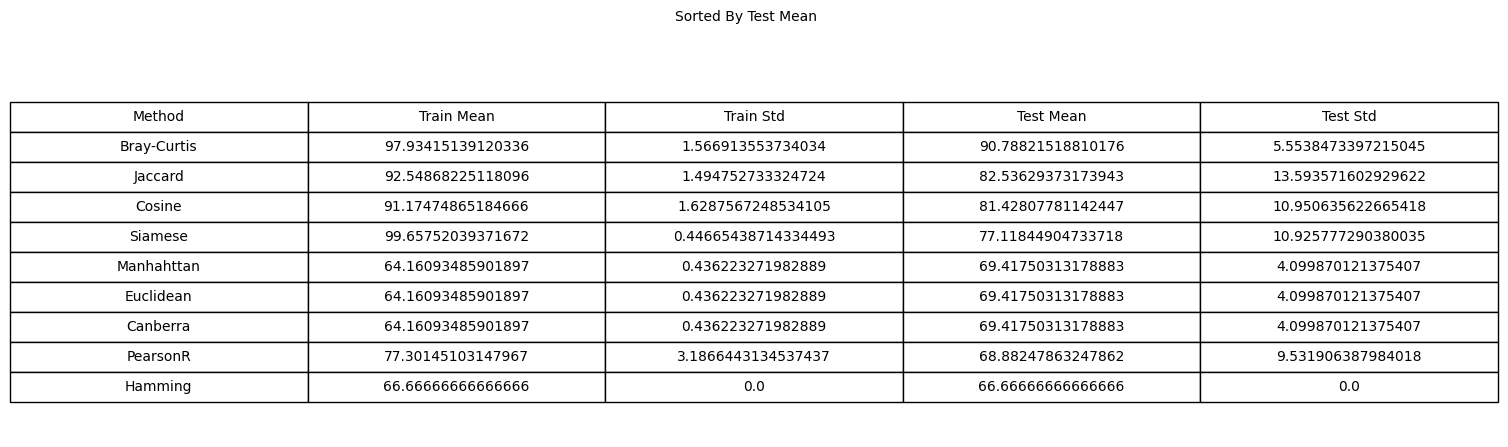

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for your table (as previously organized)
methods = ["Siamese", "Cosine", "Manhahttan", "Euclidean", "Bray-Curtis",  "PearsonR", "Jaccard", "Hamming", "Canberra"]
train_means = [np.mean(cvTrainscores), np.mean(cvTrainscoresCosine), np.mean(cvTrainscoresManhattan),
               np.mean(cvTrainscoresEuclidean), np.mean(cvTrainscoresBrayCurtis),
               np.mean(cvTrainscoresPearsonR), np.mean(cvTrainscoresJaccard), np.mean(cvTrainscoresHamming),
               np.mean(cvTrainscoresCanberra)]
train_stds = [np.std(cvTrainscores), np.std(cvTrainscoresCosine), np.std(cvTrainscoresManhattan),
              np.std(cvTrainscoresEuclidean), np.std(cvTrainscoresBrayCurtis), 
              np.std(cvTrainscoresPearsonR), np.std(cvTrainscoresJaccard), np.std(cvTrainscoresHamming),
              np.std(cvTrainscoresCanberra)]
test_means = [np.mean(cvTestscores), np.mean(cvTestscoresCosine), np.mean(cvTestscoresManhattan),
              np.mean(cvTestscoresEuclidean), np.mean(cvTestscoresBrayCurtis),
              np.mean(cvTestscoresPearsonR), np.mean(cvTestscoresJaccard), np.mean(cvTestscoresHamming),
              np.mean(cvTestscoresCanberra)]
test_stds = [np.std(cvTestscores), np.std(cvTestscoresCosine), np.std(cvTestscoresManhattan),
             np.std(cvTestscoresEuclidean), np.std(cvTestscoresBrayCurtis), 
             np.std(cvTestscoresPearsonR), np.std(cvTestscoresJaccard), np.std(cvTestscoresHamming),
             np.std(cvTestscoresCanberra)]

# Create a list of indices for sorting based on "Test Mean" values
sorted_indices = sorted(range(len(test_means)), key=lambda i: test_means[i], reverse=True)

# Sort all the data based on the sorted indices
sorted_methods = [methods[i] for i in sorted_indices]
sorted_train_means = [train_means[i] for i in sorted_indices]
sorted_train_stds = [train_stds[i] for i in sorted_indices]
sorted_test_means = [test_means[i] for i in sorted_indices]
sorted_test_stds = [test_stds[i] for i in sorted_indices]

# Create a figure and axis
fig, ax = plt.subplots()

# Organize the sorted data into a 2D array
sorted_data = [sorted_methods, sorted_train_means, sorted_train_stds, sorted_test_means, sorted_test_stds]
sorted_data = list(map(list, zip(*sorted_data)))  # Transpose the data

# Define the column labels
column_labels = ["Method", "Train Mean", "Train Std", "Test Mean", "Test Std"]

# Create the table
table = ax.table(cellText=sorted_data, colLabels=column_labels, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(3, 1.8)  # Adjust the table size

# Remove the axis
ax.axis('off')

# Add a title to the figure
fig.suptitle('Sorted By Test Mean', fontsize=10, y=1)

# Show the table
plt.show()


In [ ]:
Manhattan Distance   0.100           0.667     
2    Euclidean Distance   0.100           0.667     
3    Canberra Distance    0.100           0.667     
4    Hamming Distance     0.100           0.667     
5    Bray-Curtis Distance 0.850           0.667     
6    Cosine Similarity    0.150           0.632     
7    Pearson Correlation  0.100           0.632     
8    Jaccard Similarity   0.100           0.625     


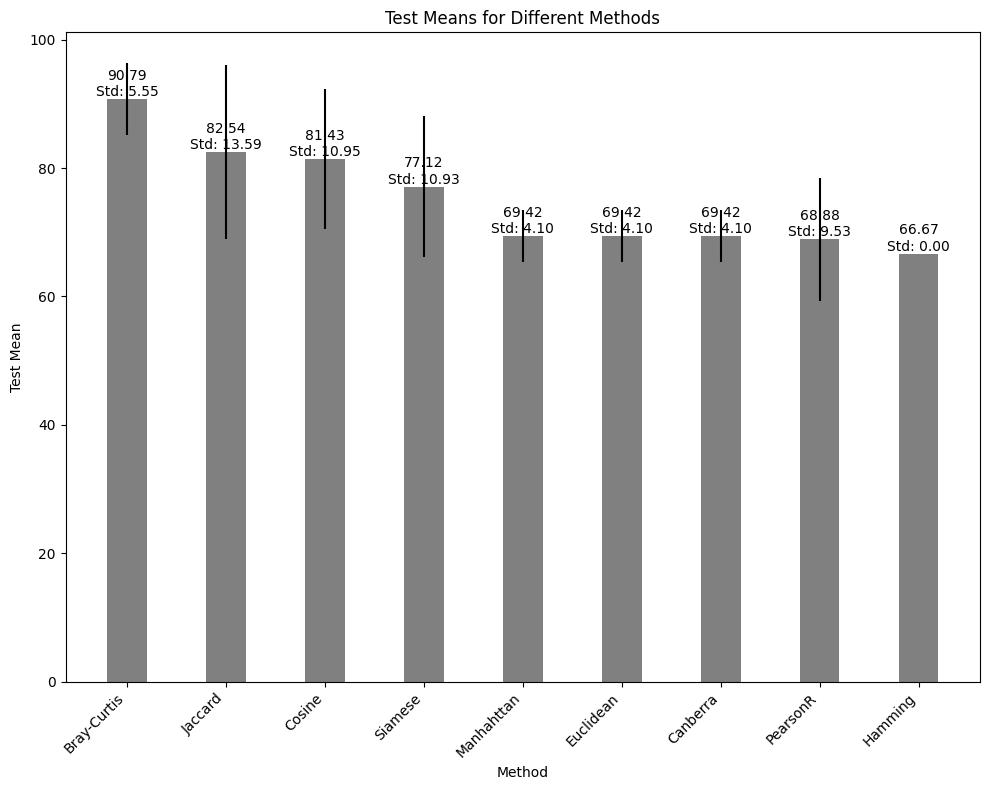

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis for the histogram of test means
fig_test, ax_test = plt.subplots(figsize=(10, 8))



# Number of bars (one for each method)
num_methods = len(sorted_methods)
bar_width = 0.4
index = np.arange(num_methods)

# Create bars for train means
bar1_test = ax_test.bar(index, sorted_test_means, bar_width, label='Train Mean', yerr=sorted_test_stds, color='grey')

# Set the x-axis labels to be the sorted method names
ax_test.set_xticks(index)
ax_test.set_xticklabels(sorted_methods, rotation=45, ha='right')

# Add labels and title
ax_test.set_xlabel('Method')
ax_test.set_ylabel('Test Mean')
ax_test.set_title('Test Means for Different Methods')


# Annotate the bars with their standard deviations below the bars
for i, (v, std) in enumerate(zip(sorted_test_means, sorted_test_stds)):
    ax_test.text(i, v +0.01, f"{v:.2f}\nStd: {std:.2f}", ha='center', va='bottom', fontsize=10)

# Show the plot for test means
plt.tight_layout()
plt.show()




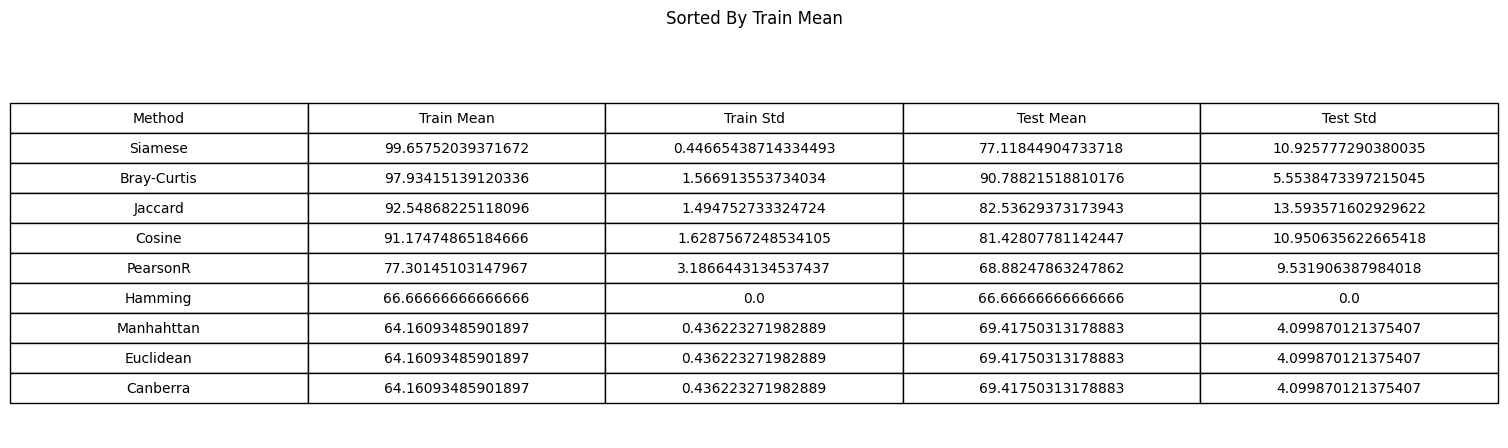

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for your table (as previously organized)
methods = ["Siamese", "Cosine", "Manhahttan", "Euclidean", "Bray-Curtis","PearsonR", "Jaccard", "Hamming", "Canberra"]
train_means = [np.mean(cvTrainscores), np.mean(cvTrainscoresCosine), np.mean(cvTrainscoresManhattan),
               np.mean(cvTrainscoresEuclidean), np.mean(cvTrainscoresBrayCurtis),
               np.mean(cvTrainscoresPearsonR), np.mean(cvTrainscoresJaccard), np.mean(cvTrainscoresHamming),
               np.mean(cvTrainscoresCanberra)]
train_stds = [np.std(cvTrainscores), np.std(cvTrainscoresCosine), np.std(cvTrainscoresManhattan),
              np.std(cvTrainscoresEuclidean), np.std(cvTrainscoresBrayCurtis), 
              np.std(cvTrainscoresPearsonR), np.std(cvTrainscoresJaccard), np.std(cvTrainscoresHamming),
              np.std(cvTrainscoresCanberra)]
test_means = [np.mean(cvTestscores), np.mean(cvTestscoresCosine), np.mean(cvTestscoresManhattan),
              np.mean(cvTestscoresEuclidean), np.mean(cvTestscoresBrayCurtis),
              np.mean(cvTestscoresPearsonR), np.mean(cvTestscoresJaccard), np.mean(cvTestscoresHamming),
              np.mean(cvTestscoresCanberra)]
test_stds = [np.std(cvTestscores), np.std(cvTestscoresCosine), np.std(cvTestscoresManhattan),
             np.std(cvTestscoresEuclidean), np.std(cvTestscoresBrayCurtis), 
             np.std(cvTestscoresPearsonR), np.std(cvTestscoresJaccard), np.std(cvTestscoresHamming),
             np.std(cvTestscoresCanberra)]


# Create a list of indices for sorting based on "Train Mean" values
sorted_indices = sorted(range(len(train_means)), key=lambda i: train_means[i], reverse=True)

# Sort all the data based on the sorted indices
sorted_methods = [methods[i] for i in sorted_indices]
sorted_train_means = [train_means[i] for i in sorted_indices]
sorted_train_stds = [train_stds[i] for i in sorted_indices]
sorted_test_means = [test_means[i] for i in sorted_indices]
sorted_test_stds = [test_stds[i] for i in sorted_indices]

# Create a figure and axis
fig, ax = plt.subplots()

# Organize the sorted data into a 2D array
sorted_data = [sorted_methods, sorted_train_means, sorted_train_stds, sorted_test_means, sorted_test_stds]
sorted_data = list(map(list, zip(*sorted_data)))  # Transpose the data

# Define the column labels
column_labels = ["Method", "Train Mean", "Train Std", "Test Mean", "Test Std"]

# Create the table
table = ax.table(cellText=sorted_data, colLabels=column_labels, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(3, 1.8)  # Adjust the table size

# Add a title to the figure
plt.title('Sorted By Train Mean', fontsize=12, y=1.1)  # Adjust fontsize and position

# Remove the axis
ax.axis('off')

# Show the table
plt.show()


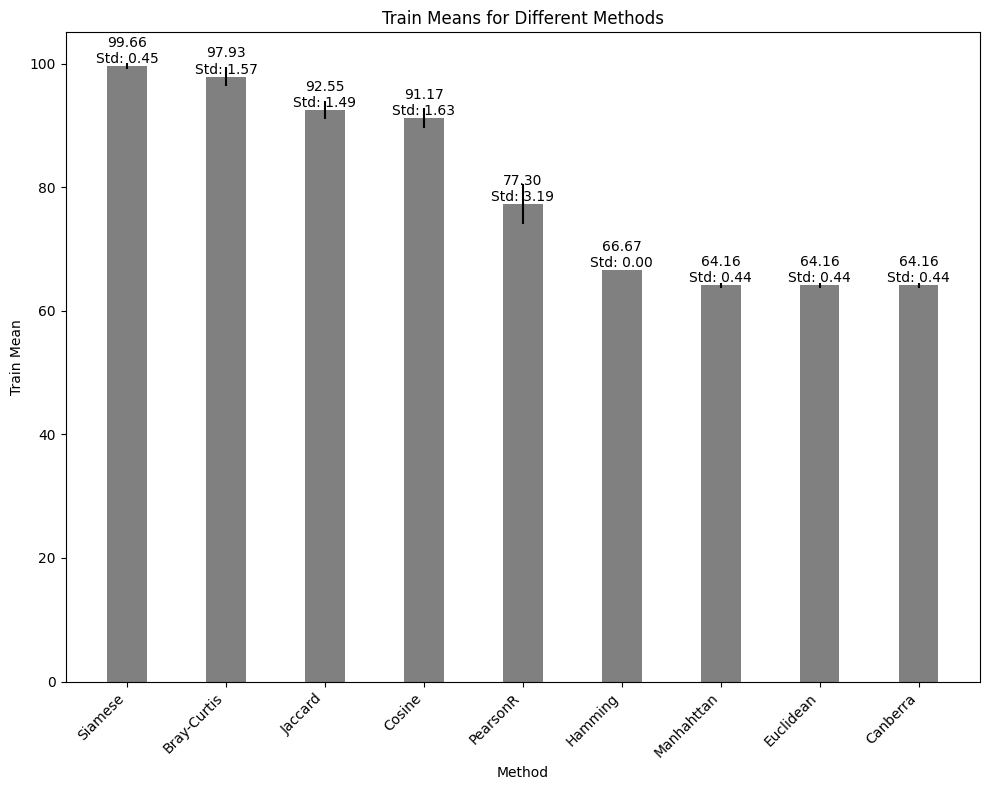

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis for the histogram of train means
fig_train, ax_train = plt.subplots(figsize=(10, 8))



# Number of bars (one for each method)
num_methods = len(sorted_methods)
bar_width = 0.4
index = np.arange(num_methods)

# Create bars for train means
bar1_train = ax_train.bar(index, sorted_train_means, bar_width, label='Train Mean', yerr=sorted_train_stds, color='grey')

# Set the x-axis labels to be the sorted method names
ax_train.set_xticks(index)
ax_train.set_xticklabels(sorted_methods, rotation=45, ha='right')

# Add labels and title
ax_train.set_xlabel('Method')
ax_train.set_ylabel('Train Mean')
ax_train.set_title('Train Means for Different Methods')


# Annotate the bars with their standard deviations below the bars
for i, (v, std) in enumerate(zip(sorted_train_means, sorted_train_stds)):
    ax_train.text(i, v +0.01, f"{v:.2f}\nStd: {std:.2f}", ha='center', va='bottom', fontsize=10)
# Show the plot for train means
plt.tight_layout()
plt.show()


In [32]:
# Similarity Calculation Step (Process Group 2)
import csv
table_name = df[0]
with open('pairwise_similarity_calculation_result.txt','w') as f1:
    writer=csv.writer(f1, delimiter=';',lineterminator='\n',)
    for i in range(np.shape(X)[0]):
        for y in range(np.shape(X)[0]):
            siamese_result = model.predict([X[i].reshape(1,376,1), X[y].reshape(1,376,1)])
            print(table_name[i]+';'+table_name[y]+';'+' '.join(map(str, siamese_result[0])))
            writer.writerow(list([table_name[i]+';'+table_name[y]+';'+' '.join(map(str, siamese_result[0]))]))

1/1 [==============================] - 0s 141ms/step
TABLE_1_1;TABLE_1_1;0.00031622776
1/1 [==============================] - 0s 22ms/step
TABLE_1_1;TABLE_2_1;0.1458466
1/1 [==============================] - 0s 20ms/step
TABLE_1_1;TABLE_3_1;0.1458466
1/1 [==============================] - 0s 16ms/step
TABLE_1_1;TABLE_4_1;0.24895717
1/1 [==============================] - 0s 18ms/step
TABLE_1_1;TABLE_5_1;0.24895717
1/1 [==============================] - 0s 21ms/step
TABLE_1_1;TABLE_6_1;0.32344216
1/1 [==============================] - 0s 19ms/step
TABLE_1_1;TABLE_7_1;0.26313916
1/1 [==============================] - 0s 22ms/step
TABLE_1_1;TABLE_8_1;0.40623674
1/1 [==============================] - 0s 18ms/step
TABLE_1_1;TABLE_9_1;0.26313916
1/1 [==============================] - 0s 23ms/step
TABLE_1_1;TABLE_10_1;0.26313916
1/1 [==============================] - 0s 25ms/step
TABLE_1_1;TABLE_11_2;0.8102011
1/1 [==============================] - 0s 22ms/step
TABLE_1_1;TABLE_12_2;0.73241943


KeyboardInterrupt: 

In [38]:
from scipy.spatial.distance import braycurtis
import csv

table_name = df[0]
with open('pairwise_similarity_calculation_result.txt','w') as f1:
    writer = csv.writer(f1, delimiter=';', lineterminator='\n')
    for i in range(np.shape(X)[0]):
        for y in range(np.shape(X)[0]):
            # Get modified table names without numbers following underscores
            modified_table1 = '_'.join(table_name[i].split('_')[:-1])
            modified_table2 = '_'.join(table_name[y].split('_')[:-1])
            
            # Calculate Bray-Curtis distance
            distance = braycurtis(X[i], X[y])
            
            # Write to file if the distance is greater than 0.5
            if distance < 0.5 and distance != 0:
                formatted_distance = "{:.3f}".format(distance)  # Format distance with 3 decimal places
                print(modified_table1 + ';' + modified_table2 + ';' + formatted_distance)
                writer.writerow([modified_table1, modified_table2, formatted_distance])


TABLE_1;TABLE_2;0.143
TABLE_1;TABLE_3;0.143
TABLE_1;TABLE_4;0.333
TABLE_1;TABLE_5;0.333
TABLE_1;TABLE_6;0.400
TABLE_1;TABLE_7;0.455
TABLE_1;TABLE_8;0.455
TABLE_1;TABLE_9;0.455
TABLE_1;TABLE_10;0.455
TABLE_2;TABLE_1;0.143
TABLE_2;TABLE_4;0.200
TABLE_2;TABLE_5;0.200
TABLE_2;TABLE_6;0.455
TABLE_2;TABLE_7;0.333
TABLE_2;TABLE_8;0.333
TABLE_2;TABLE_9;0.333
TABLE_2;TABLE_10;0.333
TABLE_3;TABLE_1;0.143
TABLE_3;TABLE_4;0.200
TABLE_3;TABLE_5;0.200
TABLE_3;TABLE_6;0.455
TABLE_3;TABLE_7;0.333
TABLE_3;TABLE_8;0.333
TABLE_3;TABLE_9;0.333
TABLE_3;TABLE_10;0.333
TABLE_4;TABLE_1;0.333
TABLE_4;TABLE_2;0.200
TABLE_4;TABLE_3;0.200
TABLE_4;TABLE_6;0.385
TABLE_4;TABLE_7;0.143
TABLE_4;TABLE_8;0.286
TABLE_4;TABLE_9;0.143
TABLE_4;TABLE_10;0.143
TABLE_5;TABLE_1;0.333
TABLE_5;TABLE_2;0.200
TABLE_5;TABLE_3;0.200
TABLE_5;TABLE_6;0.385
TABLE_5;TABLE_7;0.143
TABLE_5;TABLE_8;0.286
TABLE_5;TABLE_9;0.143
TABLE_5;TABLE_10;0.143
TABLE_6;TABLE_1;0.400
TABLE_6;TABLE_2;0.455
TABLE_6;TABLE_3;0.455
TABLE_6;TABLE_4;0.385
TABLE